# Hello Bluesky: Reading detectors and scanning

In this notebook you will:

* Connect to some simulated hardware.
* Acquire some data via two common experimental procedures ("plans"), ``count`` and ``scan``.
* Write a custom plan.

Recommend Prerequisites:

* [Hello Python and Jupyter](./Hello%20Python%20and%20Jupyter.ipynb)

## Configuration
Below, we will connect to EPICS IOC(s) controlling simulated hardware in lieu of actual motors and detectors. An EPICS IOC is control system software that allows communication with a wide variety of hardware using a common interface. The IOCs should already be running in the background. Run this command to verify that they are running: it should produce output with RUNNING on each line. In the event of a problem, edit this command to replace `status` with `restart all` and run again.

In [1]:
%matplotlib widget

In [2]:
!supervisorctl -c supervisor/supervisord.conf status

decay                            RUNNING   pid 4880, uptime 0:01:05
mini_beamline                    RUNNING   pid 4881, uptime 0:01:05
random_walk                      RUNNING   pid 4882, uptime 0:01:05
random_walk_horiz                RUNNING   pid 4883, uptime 0:01:05
random_walk_vert                 RUNNING   pid 4884, uptime 0:01:05
simple                           RUNNING   pid 4885, uptime 0:01:05
thermo_sim                       RUNNING   pid 4886, uptime 0:01:05
trigger_with_pc                  RUNNING   pid 4887, uptime 0:01:05


In [3]:
%run scripts/beamline_configuration.py

In [4]:
# aliases for convenience/readability
motor = motor_ph
det = ph

Check that we can communicate with the hardware. If this doesn't raise an error, it worked.

In [5]:
det.wait_for_connection()

## Data Acquisition

### Executing a `count` plan with various parameters

In the example below, the Bluesky run engine is the interpreter of experiment plans and `count` is an experiment plan used here to acquire one reading from a point detector.

In [6]:
from bluesky.plans import count
RE(count([det]))



Transient Scan ID: 4     Time: 2020-05-17 19:54:21
Persistent Unique Scan ID: 'debe148c-806f-435b-b7b2-db9e446b645f'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 19:54:21.4 |     101300 |
+-----------+------------+------------+
generator count ['debe148c'] (scan num: 4)





('debe148c-806f-435b-b7b2-db9e446b645f',)

The return value is a list of the run IDs that uniquely identify this data set. The "scan num" is easier to remember but is not good for long-term reference because it may not be unique.

Let's looks at the documentation for `count` to see what our other options are.

In [7]:
help(count)  # or, equiavently, type count? or ?count

Help on function count in module bluesky.plans:

count(detectors, num=1, delay=None, *, per_shot=None, md=None)
    Take one or more readings from detectors.
    
    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    num : integer, optional
        number of readings to take; default is 1
    
        If None, capture data until canceled
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.
    per_shot : callable, optional
        hook for customizing action of inner loop (messages per step)
        Expected signature ::
    
           def f(detectors: Iterable[OphydObj]) -> Generator[Msg]:
               ...
    
    md : dict, optional
        metadata
    
    Notes
    -----
    If ``delay`` is an iterable, it must have at least ``num - 1`` entries or
    the plan will raise a ``ValueError`` during iteration.



In [8]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [9]:
# five consecutive readings
RE(count([det], num=5))



Transient Scan ID: 5     Time: 2020-05-17 19:54:21
Persistent Unique Scan ID: '669777d9-cc9d-4fe2-90b7-7a5b92fd41c5'
New stream: 'primary'


+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 19:54:21.6 |     102183 |
|         2 | 19:54:21.6 |     102566 |
|         3 | 19:54:21.6 |     102117 |
|         4 | 19:54:21.6 |     102828 |
|         5 | 19:54:21.6 |     102252 |


+-----------+------------+------------+
generator count ['669777d9'] (scan num: 5)





('669777d9-cc9d-4fe2-90b7-7a5b92fd41c5',)

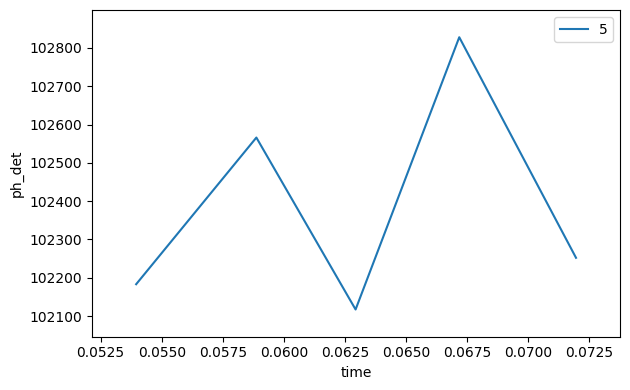

In [10]:
plt.gcf()  # Display a snapshot of the current state of the figure.

In [11]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# five sequential readings separated by a 1-second delay
RE(count([det], num=5, delay=1))



Transient Scan ID: 6     Time: 2020-05-17 19:54:22
Persistent Unique Scan ID: '514196e0-bbaa-4e4f-ac54-d39587077bb2'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 19:54:22.1 |     102730 |


|         2 | 19:54:23.1 |      96830 |


|         3 | 19:54:24.1 |      92501 |


|         4 | 19:54:25.1 |      99203 |


|         5 | 19:54:26.1 |     102956 |


+-----------+------------+------------+
generator count ['514196e0'] (scan num: 6)





('514196e0-bbaa-4e4f-ac54-d39587077bb2',)

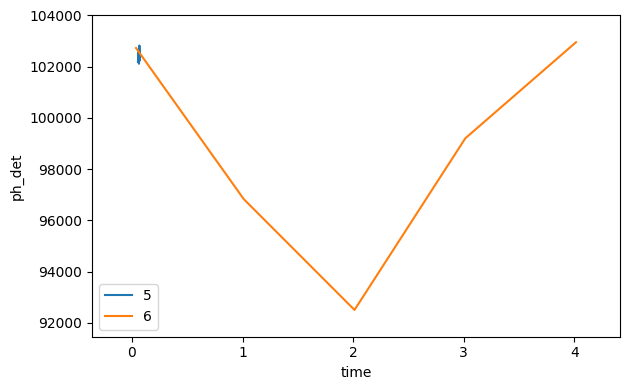

In [13]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Scan

Scan ``motor`` from -10 to 10, stopping at 15 equally-spaced points along the way and reading ``det``.

In [14]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs motor_ph')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [15]:
RE(scan([det], motor, -10, 10, 15))



Transient Scan ID: 7     Time: 2020-05-17 19:54:27
Persistent Unique Scan ID: 'f6e383b9-ee7d-41e6-a934-88abc351aa1a'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 19:54:27.8 |    -10.000 |      12900 |
|         2 | 19:54:27.8 |     -8.571 |      21728 |
|         3 | 19:54:27.8 |     -7.143 |      34341 |
|         4 | 19:54:27.8 |     -5.714 |      49203 |
|         5 | 19:54:27.9 |     -4.286 |      65764 |
|         6 | 19:54:27.9 |     -2.857 |      80662 |
|         7 | 19:54:27.9 |     -1.429 |      91726 |


|         8 | 19:54:28.0 |      0.000 |      95376 |
|         9 | 19:54:28.0 |      1.429 |      90953 |
|        10 | 19:54:28.0 |      2.857 |      80759 |
|        11 | 19:54:28.0 |      4.286 |      66168 |
|        12 | 19:54:28.0 |      5.714 |      49458 |
|        13 | 19:54:28.0 |      7.143 |      34141 |
|        14 | 19:54:28.0 |      8.571 |      21773 |
|        15 | 19:54:28.0 |     10.000 |      12958 |
+-----------+------------+------------+------------+
generator scan ['f6e383b9'] (scan num: 7)





('f6e383b9-ee7d-41e6-a934-88abc351aa1a',)

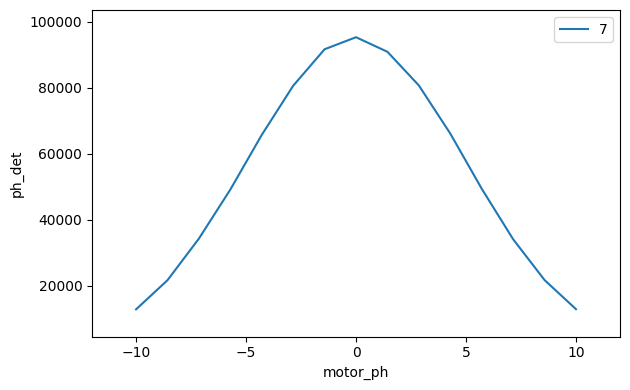

In [16]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Simulators

Bluesky includes utilities to inspecting plans before they are run. You can imagine various reasons you might want to do this. Example:

In [17]:
from bluesky.simulators import summarize_plan

summarize_plan(scan([det], motor, -1, 1, 3))

=================================== Open Run ===================================
motor_ph -> -1.0
  Read ['ph', 'motor_ph']
motor_ph -> 0.0
  Read ['ph', 'motor_ph']
motor_ph -> 1.0
  Read ['ph', 'motor_ph']
================================== Close Run ===================================


### Custom plan

Define a custom "plan", using the Python syntax ``yield from`` to dispatch out to built-in plans.

In [18]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# The plan_stubs module contains smaller plans.
# They can be used alone or as buildling blocks for larger plans.
from bluesky.plan_stubs import mv


def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        yield from mv(det.exp, t)
        yield from scan([det], motor, -10, 10, 5)
        
RE(sweep_exposure_time([0.01, 0.1, 1]))



Transient Scan ID: 8     Time: 2020-05-17 19:54:28
Persistent Unique Scan ID: '8b5ad58d-f8d4-4a6d-b4e6-9e13f85897b2'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 19:54:28.9 |    -10.000 |        140 |
|         2 | 19:54:29.0 |     -5.000 |        626 |


|         3 | 19:54:29.1 |      0.000 |       1047 |
|         4 | 19:54:29.2 |      5.000 |        630 |


|         5 | 19:54:29.3 |     10.000 |        127 |
+-----------+------------+------------+------------+
generator scan ['8b5ad58d'] (scan num: 8)





Transient Scan ID: 9     Time: 2020-05-17 19:54:29
Persistent Unique Scan ID: 'd3b4580a-d428-4d9d-8657-3cf284812117'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 19:54:29.9 |    -10.000 |       1391 |
|         2 | 19:54:30.1 |     -5.000 |       6465 |


|         3 | 19:54:30.2 |      0.000 |      10565 |
|         4 | 19:54:30.3 |      5.000 |       6201 |


|         5 | 19:54:30.4 |     10.000 |       1445 |
+-----------+------------+------------+------------+
generator scan ['d3b4580a'] (scan num: 9)





Transient Scan ID: 10     Time: 2020-05-17 19:54:30
Persistent Unique Scan ID: '73748b6c-e171-4702-bc14-579bdf53d22e'


New stream: 'primary'


+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 19:54:31.1 |    -10.000 |      13535 |
|         2 | 19:54:31.2 |     -5.000 |      59181 |


|         3 | 19:54:31.3 |      0.000 |      97191 |
|         4 | 19:54:31.4 |      5.000 |      58173 |


|         5 | 19:54:31.5 |     10.000 |      12967 |
+-----------+------------+------------+------------+
generator scan ['73748b6c'] (scan num: 10)





('8b5ad58d-f8d4-4a6d-b4e6-9e13f85897b2',
 'd3b4580a-d428-4d9d-8657-3cf284812117',
 '73748b6c-e171-4702-bc14-579bdf53d22e')

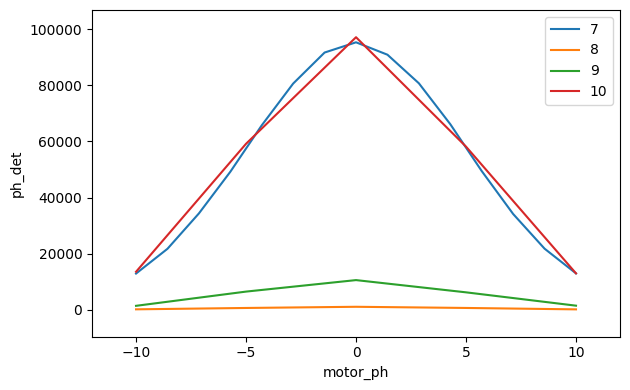

In [20]:
plt.gcf()  # Display a snapshot of the current state of the figure.

## Exercises

Q1: Above we ran a `count` with multiple readings separated by a fixed delay. The ``delay`` parameter also accepts a list of values. Try a `count` with a variable delay.


In [21]:
# Try your solution here. Fill in the blank:
# RE(count(____)))

Execute the following cell to reveal a solution:

In [22]:
%load solutions/count_variable_delay.py

Q2: Write a custom plan that scans the same region twice, first with coarse steps and then with fine steps.

In [23]:
# Try your solution here. Fill in the blank:
# def coarse_and_fine(detectors, motor, start, stop):
#     yield from scan(___)
#     yield from scan(___)
#
# RE(coarse_and_fine([det], motor, -10, 10))

In [24]:
%load solutions/scan_coarse_and_fine.py

Q3. All of the usages of scan we have seen so far scan from negative to positive. Scan from positive to negative.

In [25]:
# Try your solution here.

In [26]:
%load solutions/scan_positive_to_negative.py

Q4: The ``scan`` plan samples equally-spaced points. To sample *arbitrary* points, you can use ``list_scan``. Import it from the same module that we imported ``scan`` from, then use ``list_scan?`` to view its documentation and figure out how to use it. Scan the positions ``[1, 1, 2, 3, 5, 8]``.

In [27]:
# Try your solution here.

In [28]:
%load solutions/scan_fibonacci.py

Q5: What's wrong with this? (What does it do?)

In [29]:
# Broken example
def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        mv(det.exp, t)
        scan([det], motor, -10, 10, 15)

In [30]:
%load solutions/broken_sweep_exposure_time_explanation.txt